# Colab E1 — TensorFlow Low-Level / From Scratch (No Keras Layers/Model) — 3-hidden-layer DNN for Non-Linear Regression

**Key requirements satisfied (E1):**
- Synthetic **3-variable** non-linear regression dataset (x1, x2, x3 → y)
- **Deep network with 3 hidden layers**
- **Low-level TensorFlow**: we use `tf.Variable`, `tf.GradientTape`, and a custom forward pass  
- **No `tf.keras.layers.Dense`, no `tf.keras.Model`, no `model.fit()`**
- Training uses **manual SGD updates** (we apply gradients ourselves)
- Shows **loss vs epochs** and **final predicted vs true** output plot
- Includes “4D” visualization: PCA (3D X → 2D) then plot (PC1, PC2, y) with color = x3


In [1]:
# =========================
# Cell 1 — Setup
# =========================
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

np.random.seed(7)
tf.random.set_seed(7)

print("TF version:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))


TF version: 2.19.0
GPU available: False


In [2]:
# =========================
# Cell 2 — Synthetic data (3 variables) + preprocessing
# =========================
N = 2000
X = np.random.uniform(-2.0, 2.0, size=(N, 3)).astype(np.float32)
x1, x2, x3 = X[:, 0], X[:, 1], X[:, 2]

noise = 0.10 * np.random.randn(N).astype(np.float32)
y = (
    np.sin(x1)
    + 0.5 * np.cos(x2 * x3)
    + 0.30 * (x2 ** 2)
    - 0.20 * (x3 ** 3)
    + 0.25 * np.sin(x1 * x2)
    + noise
).astype(np.float32).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

# Standardize (train stats only)
X_mu, X_std = X_train.mean(axis=0, keepdims=True), X_train.std(axis=0, keepdims=True) + 1e-8
y_mu, y_std = y_train.mean(axis=0, keepdims=True), y_train.std(axis=0, keepdims=True) + 1e-8

X_train_n = (X_train - X_mu) / X_std
X_test_n  = (X_test  - X_mu) / X_std
y_train_n = (y_train - y_mu) / y_std
y_test_n  = (y_test  - y_mu) / y_std

print("Shapes:", X_train_n.shape, y_train_n.shape, X_test_n.shape, y_test_n.shape)


Shapes: (1600, 3) (1600, 1) (400, 3) (400, 1)


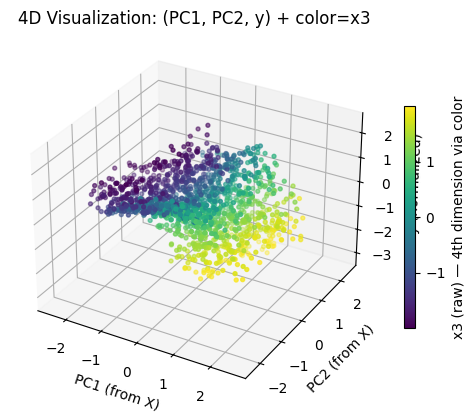

In [3]:
# =========================
# Cell 3 — 4D visualization (PCA for X, color = x3)
# =========================
pca = PCA(n_components=2, random_state=7)
X2 = pca.fit_transform(X_train_n)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X2[:, 0], X2[:, 1], y_train_n[:, 0], c=X_train[:, 2], s=8)

ax.set_xlabel("PC1 (from X)")
ax.set_ylabel("PC2 (from X)")
ax.set_zlabel("y (normalized)")
fig.colorbar(sc, ax=ax, shrink=0.6, label="x3 (raw) — 4th dimension via color")
plt.title("4D Visualization: (PC1, PC2, y) + color=x3")
plt.show()


In [4]:
# =========================
# Cell 4 — Parameters + forward pass (NO Keras layers)
# =========================
def init_var(shape, scale=0.1):
    return tf.Variable(tf.random.normal(shape, stddev=scale, dtype=tf.float32))

# 3 hidden layers
H1, H2, H3 = 32, 32, 16
W1, b1 = init_var((3,  H1)), tf.Variable(tf.zeros([H1], dtype=tf.float32))
W2, b2 = init_var((H1, H2)), tf.Variable(tf.zeros([H2], dtype=tf.float32))
W3, b3 = init_var((H2, H3)), tf.Variable(tf.zeros([H3], dtype=tf.float32))
W4, b4 = init_var((H3, 1 )), tf.Variable(tf.zeros([1],  dtype=tf.float32))

def relu(z): return tf.maximum(z, 0.0)
def tanh(z): return tf.tanh(z)

@tf.function
def forward(Xb):
    Z1 = tf.einsum("bi,ij->bj", Xb, W1) + b1
    A1 = tanh(Z1)
    Z2 = tf.einsum("bi,ij->bj", A1, W2) + b2
    A2 = relu(Z2)
    Z3 = tf.einsum("bi,ij->bj", A2, W3) + b3
    A3 = tanh(Z3)
    Yhat = tf.einsum("bi,ij->bj", A3, W4) + b4  # linear output
    return Yhat

train_vars = [W1, b1, W2, b2, W3, b3, W4, b4]


Epoch   1 | Loss (MSE, normalized): 0.988203
Epoch  50 | Loss (MSE, normalized): 0.153591
Epoch 100 | Loss (MSE, normalized): 0.102333
Epoch 150 | Loss (MSE, normalized): 0.069672
Epoch 200 | Loss (MSE, normalized): 0.057103
Epoch 250 | Loss (MSE, normalized): 0.049564
Epoch 300 | Loss (MSE, normalized): 0.046705


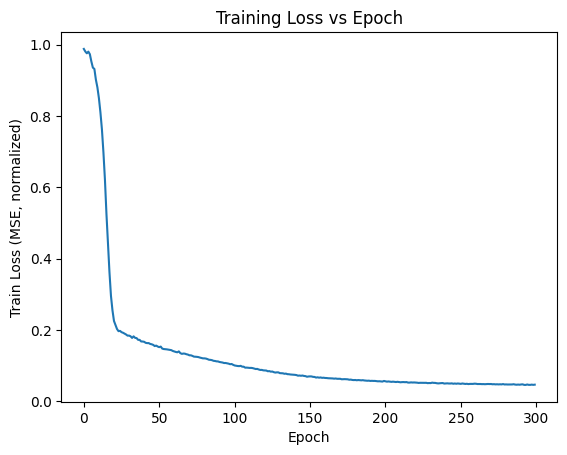

In [5]:
# =========================
# Cell 5 — Training loop (GradientTape + manual SGD)
# =========================
def mse(yhat, ytrue):
    return tf.reduce_mean(tf.square(yhat - ytrue))

Xtr = tf.constant(X_train_n, dtype=tf.float32)
ytr = tf.constant(y_train_n, dtype=tf.float32)

epochs = 300
batch_size = 128
lr = 0.01

losses = []
n = X_train_n.shape[0]

for ep in range(1, epochs + 1):
    idx = np.random.permutation(n)
    ep_loss = 0.0
    steps = 0

    for start in range(0, n, batch_size):
        bi = idx[start:start + batch_size]
        Xb = tf.gather(Xtr, bi)
        yb = tf.gather(ytr, bi)

        with tf.GradientTape() as tape:
            yhat = forward(Xb)
            loss = mse(yhat, yb)

        grads = tape.gradient(loss, train_vars)

        # Manual SGD update (no optimizer object)
        for v, g in zip(train_vars, grads):
            v.assign_sub(lr * g)

        ep_loss += float(loss.numpy())
        steps += 1

    ep_loss /= steps
    losses.append(ep_loss)

    if ep % 50 == 0 or ep == 1:
        print(f"Epoch {ep:3d} | Loss (MSE, normalized): {ep_loss:.6f}")

plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Train Loss (MSE, normalized)")
plt.title("Training Loss vs Epoch")
plt.show()


Test MSE (normalized): 0.046025
Test MSE (original scale): 0.049600


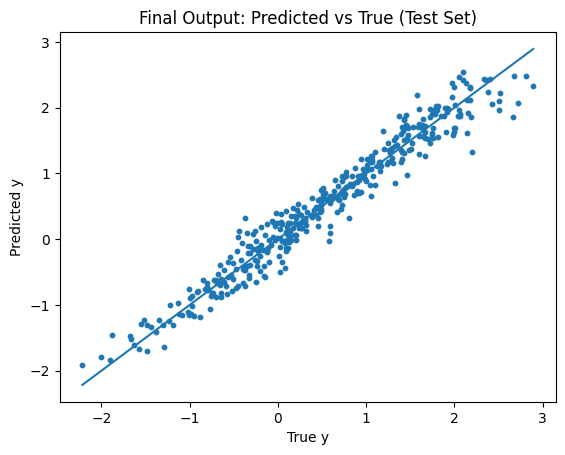

Sample 0: true= 0.0281 | pred=-0.1241
Sample 1: true= 1.2483 | pred= 1.4685
Sample 2: true=-0.7661 | pred=-1.0672
Sample 3: true= 1.8116 | pred= 2.0285
Sample 4: true= 1.6677 | pred= 1.7280


In [6]:
# =========================
# Cell 6 — Evaluation + final output
# =========================
Xte = tf.constant(X_test_n, dtype=tf.float32)
yte = tf.constant(y_test_n, dtype=tf.float32)

yhat_n = forward(Xte)
test_mse_n = float(tf.reduce_mean(tf.square(yhat_n - yte)).numpy())

# Unnormalize
yhat = (yhat_n.numpy() * y_std + y_mu).reshape(-1, 1)
ytrue = y_test
test_mse = float(np.mean((yhat - ytrue) ** 2))

print(f"Test MSE (normalized): {test_mse_n:.6f}")
print(f"Test MSE (original scale): {test_mse:.6f}")

plt.figure()
plt.scatter(ytrue, yhat, s=10)
mn, mx = float(ytrue.min()), float(ytrue.max())
plt.plot([mn, mx], [mn, mx])
plt.xlabel("True y")
plt.ylabel("Predicted y")
plt.title("Final Output: Predicted vs True (Test Set)")
plt.show()

for i in range(5):
    print(f"Sample {i}: true={ytrue[i,0]: .4f} | pred={yhat[i,0]: .4f}")
